In [3]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import scipy.sparse as sparse
import scipy.sparse.linalg as sparsela
import scipy.linalg as sla
import math
from tqdm import tqdm
import time
import numpy.linalg as la 
#import pandas as pd
import random

import matplotlib 
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

random.seed(7)

In [4]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Plots 

## Price of Anarchy

In [85]:
# Unpickle the data
import pickle
MFC = pickle.load(open("data_Jan15/MFC_v2", "rb" ) )
MFG_0 = pickle.load(open("data_Jan15/MFG_tax_0_v2", "rb" ) )
MFG_1 = pickle.load(open("data_Jan15/MFG_tax_1_v2", "rb" ) )
MFG_10 = pickle.load(open("data_Jan15/MFG_tax_10_v2", "rb" ) )
MFG_25 = pickle.load(open("data_Jan15/MFG_tax_25_v2", "rb" ) )
MFG_50 = pickle.load(open("data_Jan15/MFG_tax_50_v2", "rb" ) )
MFG_75 = pickle.load(open("data_Jan15/MFG_tax_75_v2", "rb" ) )
MFG_100 = pickle.load(open("data_Jan15/MFG_tax_100_v2", "rb" ) )

In [86]:
POA_0 = MFG_0[1]/MFC[1][0,:]
POA_1 = MFG_1[1]/MFC[1][1,:]
POA_10 = MFG_10[1]/MFC[1][2,:]
POA_25 = MFG_25[1]/MFC[1][3,:]
POA_50 = MFG_50[1]/MFC[1][4,:]
POA_75 = MFG_75[1]/MFC[1][5,:]
POA_100 = MFG_100[1]/MFC[1][6,:]

In [87]:
c2Grid = np.array([100, 500, 1000, 5000])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


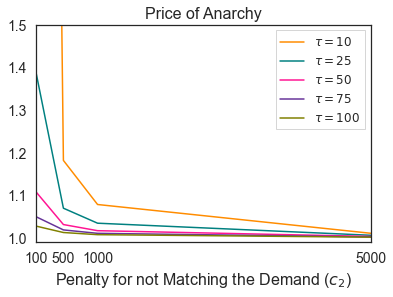

In [92]:
sns.set_style("white")
# plt.figure(figsize=(8,5))
plt.plot(c2Grid, np.array(POA_10[0][1:]), label = "$\\tau=10$", c="darkorange")
plt.plot(c2Grid, np.array(POA_25[0][1:]), label = "$\\tau=25$", c="teal")
plt.plot(c2Grid,np.array(POA_50[0][1:]), label = "$\\tau=50$", c="deeppink")
plt.plot(c2Grid, np.array(POA_75[0][1:]), label = "$\\tau=75$", c="rebeccapurple")
plt.plot(c2Grid, np.array(POA_100[0][1:]), label = "$\\tau=100$", c="olive")
plt.xlim(100,5000)
plt.ylim(0.99,1.5)
plt.xlabel('Penalty for not Matching the Demand ($c_2$)',fontdict={'fontsize':16})
plt.xticks(c2Grid)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Price of Anarchy',fontdict={'fontsize':16})
plt.legend(loc='right',bbox_to_anchor=(1.0, 0.75), fancybox=False, shadow=False, ncol =1, fontsize="12")
plt.savefig('plots/Jan26/PoA_2.eps', bbox_inches='tight', format='eps')

## Minor Cost Heat Map

In [93]:
import pandas as pd

c2Grid = np.array([50., 100., 500., 1000., 5000.])
taxGrid = np.array([0., 1., 10., 25., 50., 75., 100.])


MFC_minor_cost = pd.DataFrame(MFC[1])
MFC_minor_cost.columns = c2Grid
MFC_minor_cost.index = taxGrid
MFC_minor_cost


,50.0,100.0,500.0,1000.0,5000.0
0.0,-4.005881e+09,-2.622484e+09,2.460579e+08,1.355006e+09,5.855180e+09
1.0,-3.749137e+09,-2.297205e+09,7.094555e+08,1.849678e+09,6.379555e+09
10.0,-1.663622e+09,4.215233e+08,4.785391e+09,6.247163e+09,1.108657e+10
25.0,1.102990e+09,4.252111e+09,1.121955e+10,1.336264e+10,1.887988e+10
50.0,4.420264e+09,9.216521e+09,2.104038e+10,2.465540e+10,3.171986e+10
75.0,6.746011e+09,1.296854e+10,2.988653e+10,3.530315e+10,4.438953e+10
100.0,8.467172e+09,1.590485e+10,3.789832e+10,4.536218e+10,5.689556e+10


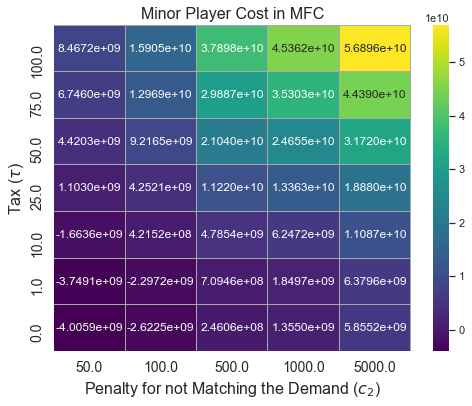

In [100]:
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 6))
# colors = ('darkslategray', 'teal')
# cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(MFC_minor_cost[::-1], linewidths=0.01, ax=ax, cmap ='viridis', linecolor="darkgray", annot=True, annot_kws={"size": 12}, fmt='.4e')
plt.ylabel('Tax ($\\tau$)',fontdict={'fontsize':16})
plt.xlabel('Penalty for not Matching the Demand ($c_2$)',fontdict={'fontsize':16})
plt.title('Minor Player Cost in MFC',fontdict={'fontsize':16})


bottom, top = ax.get_ylim()
#ax.set_ylim(bottom - 0.5, top + 0.5)

colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([0.25,0.75])
# colorbar.set_ticklabels(['Reject', 'Accept'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('plots/Jan26/minor_cost_MFC_2.eps', bbox_inches='tight', format='eps')



In [97]:
import pandas as pd

c2Grid = np.array([50., 100., 500., 1000., 5000.])
taxGrid = np.array([0., 1., 10., 25., 50., 75., 100.])


MFG_minor = np.concatenate((MFG_0[1], MFG_1[1], MFG_10[1], MFG_25[1], MFG_50[1], MFG_75[1], MFG_100[1]), axis=0)
MFG_minor_cost = pd.DataFrame(MFG_minor)
MFG_minor_cost.columns = c2Grid
MFG_minor_cost.index = taxGrid
MFG_minor_cost


,50.0,100.0,500.0,1000.0,5000.0
0.0,2.311614e+08,4.079107e+08,1.181802e+09,1.865075e+09,5.979599e+09
1.0,3.173883e+08,6.526584e+08,1.638463e+09,2.357830e+09,6.503880e+09
10.0,1.213955e+09,2.760696e+09,5.656594e+09,6.738491e+09,1.121005e+10
25.0,2.850366e+09,5.900765e+09,1.200483e+10,1.382763e+10,1.900197e+10
50.0,5.307508e+09,1.021272e+10,2.170600e+10,2.508053e+10,3.183970e+10
75.0,7.257541e+09,1.361650e+10,3.045571e+10,3.569285e+10,4.450716e+10
100.0,8.789088e+09,1.635001e+10,3.838890e+10,4.572031e+10,5.701103e+10


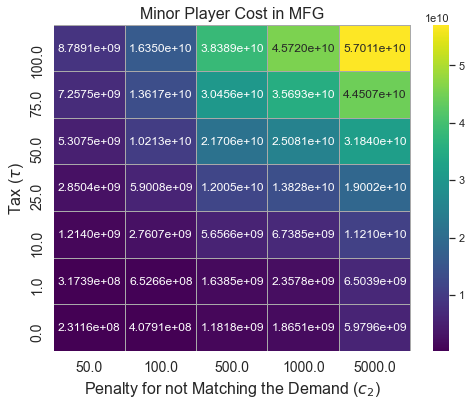

In [99]:
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 6))
# colors = ('darkslategray', 'teal')
# cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(MFG_minor_cost[::-1], linewidths=0.01, ax=ax, cmap ='viridis', linecolor="darkgray", annot=True, annot_kws={"size": 12}, fmt='.4e')
plt.ylabel('Tax ($\\tau$)',fontdict={'fontsize':16})
plt.xlabel('Penalty for not Matching the Demand ($c_2$)',fontdict={'fontsize':16})
plt.title('Minor Player Cost in MFG',fontdict={'fontsize':16})


# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom + 0.5, top - 0.5)

colorbar = ax.collections[0].colorbar
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('plots/Jan26/minor_cost_MFG_2.eps', bbox_inches='tight', format='eps')



## Pollution

In [101]:
MFC = pickle.load(open("data_Jan16/MFC_v3", "rb" ) )
MFG_0_10 = pickle.load(open("data_Jan16/MFG_v3_0_10", "rb" ) )
MFG_15_20 = pickle.load(open("data_Jan16/MFG_v3_15_20", "rb" ) )
MFG_40_50 = pickle.load(open("data_Jan16/MFG_v3_40_50", "rb" ) )

In [102]:
import numpy as np
T =     1.0 # over 20 years
Nt =    730 # number of 10 days
t_grid = np.linspace(0,T,Nt,endpoint=True) # grid on [0,T]
Delta_t = t_grid[1]-t_grid[0]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


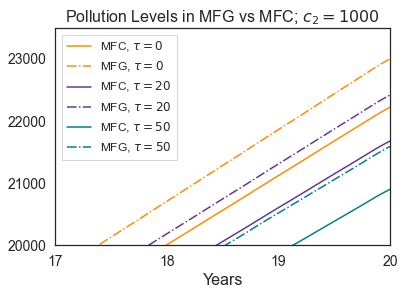

In [134]:
sns.set_style("white")
#plt.style.use('dark_background')
# plt.figure(figsize=(8,5))
plt.plot(20*t_grid, np.reshape(MFC[7][5][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFC, $\\tau=0$", c="darkorange")
plt.plot(20*t_grid, np.reshape(MFG_0_10[7][5][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFG, $\\tau=0$", c="darkorange", linestyle="-.")
plt.plot(20*t_grid, np.reshape(MFC[7][41][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFC, $\\tau=20$", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFG_15_20[7][17][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFG, $\\tau=20$", c="rebeccapurple", linestyle="-.")
plt.plot(20*t_grid, np.reshape(MFC[7][89][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFC, $\\tau=50$", c="teal")
plt.plot(20*t_grid, np.reshape(MFG_40_50[7][17][2][np.arange(3,5*Nt,5)],(np.size(t_grid))), label = "MFG, $\\tau=50$", c="teal", linestyle="-.")
plt.xlim(17.,20.0)
plt.ylim(bottom=20000, top=23500)
plt.xlabel("Years",fontdict={'fontsize':16})
plt.yticks(np.array([20000, 21000,22000,23000]))
plt.xticks(np.array([17, 18, 19,20]))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='right',bbox_to_anchor=(0.38, 0.68), fancybox=False, shadow=False, ncol =1, fontsize='12')
plt.title("Pollution Levels in MFG vs MFC; $c_2=1000$",fontdict={'fontsize':16})
plt.savefig('plots/Jan26/c2_1000_2.eps', bbox_inches='tight', format='eps')

## Planning Horizon Effect

In [292]:
import pickle
MFC_20 = pickle.load(open("data_Jan16/MFC_v3", "rb" ) )
MFC_2 = pickle.load(open("data_Jan16/MFC_time", "rb" ) )
MFG_20 = pickle.load(open("data_Jan16/MFG_v3_40_50", "rb" ) )
MFG_2 = pickle.load(open("data_Jan16/MFG_time", "rb" ) )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


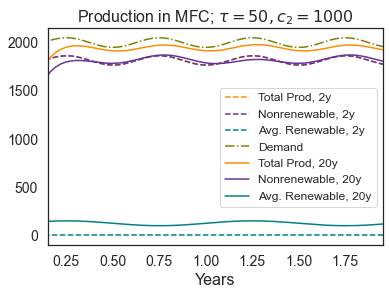

In [296]:
T =     1.0 # over 20 years
Nt =    730 # number of 10 days
t_grid = np.linspace(0,T,Nt,endpoint=True) # grid on [0,T]
Delta_t = t_grid[1]-t_grid[0]

Dt= 0.1*(20000. - 500. * np.cos(80*np.pi*t_grid) )


sns.set_style("white")
# plt.figure(figsize=(8,5))



plt.plot(2*t_grid, np.reshape(MFC_2[0][3][1,1],(np.size(t_grid))), label = "Total Prod, 2y", c="darkorange", linestyle="--")
plt.plot(2*t_grid, np.reshape(MFC_2[0][4][1,1],(np.size(t_grid))), label = "Nonrenewable, 2y", c="rebeccapurple", linestyle="--")
plt.plot(2*t_grid, np.reshape(MFC_2[0][5][1,1],(np.size(t_grid))), label = "Avg. Renewable, 2y", c='teal', linestyle="--")

plt.plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")

plt.plot(20*t_grid, 0.1 * np.reshape(MFC_20[3][7,5],(np.size(t_grid))), label = "Total Prod, 20y", c="darkorange")
plt.plot(20*t_grid, 0.1 * np.reshape(MFC_20[4][7,5],(np.size(t_grid))), label = "Nonrenewable, 20y", c="rebeccapurple")
plt.plot(20*t_grid, 0.1 * np.reshape(MFC_20[5][7,5],(np.size(t_grid))), label = "Avg. Renewable, 20y",  c='teal')



plt.xlabel("Years",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5 ,1.75]))
plt.xlim(0.15,1.95)
plt.xlabel("Years")
plt.legend(loc='right',bbox_to_anchor=(1., 0.45), ncol =1, fontsize='12')
plt.title("Production in MFC; $\\tau=50, c_2=1000$",fontdict={'fontsize':16})
# handles, labels = ax.flatten()[-2].get_legend_handles_labels()
# ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=3, handles=[line2, line5, line1, line3, line6, line4, dem])
plt.savefig('plots/Jan26/MFC_2vs20_tax_50_c2_1000_2.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


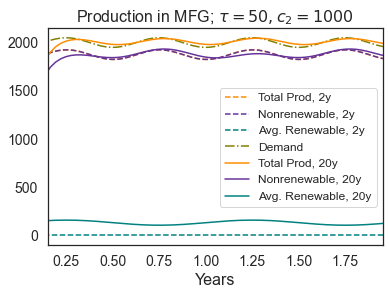

In [298]:
T =     1.0 # over 20 years
Nt =    730 # number of 10 days
t_grid = np.linspace(0,T,Nt,endpoint=True) # grid on [0,T]
Delta_t = t_grid[1]-t_grid[0]

Dt= 0.1*(20000. - 500. * np.cos(80*np.pi*t_grid) )


sns.set_style("white")

plt.plot(2*t_grid, np.reshape(MFG_2[0][3][1,1],(np.size(t_grid))), label = "Total Prod, 2y", c="darkorange", linestyle="--")
plt.plot(2*t_grid, np.reshape(MFG_2[0][4][1,1],(np.size(t_grid))), label = "Nonrenewable, 2y", c="rebeccapurple", linestyle="--")
plt.plot(2*t_grid, np.reshape(MFG_2[0][5][1,1],(np.size(t_grid))), label = "Avg. Renewable, 2y", c='teal', linestyle="--")

plt.plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")

plt.plot(20*t_grid, 0.1 * np.reshape(MFG_20[3][1,5],(np.size(t_grid))), label = "Total Prod, 20y", c="darkorange")
plt.plot(20*t_grid, 0.1 * np.reshape(MFG_20[4][1,5],(np.size(t_grid))), label = "Nonrenewable, 20y", c="rebeccapurple")
plt.plot(20*t_grid, 0.1 * np.reshape(MFG_20[5][1,5],(np.size(t_grid))), label = "Avg. Renewable, 20y",  c='teal')

# plt.xlim(0.15,1.95)
# plt.xlabel("Years")
# plt.legend(loc='right',bbox_to_anchor=(0.97, -0.35), fancybox=True, shadow=True, ncol =2, fontsize='small')
# plt.title("Production in MFG: $\\tau=50, c_2=1000$",fontdict={'fontsize':14})
# plt.savefig('plots/Jan16/MFG_2vs20_tax_50_c2_1000.eps', bbox_inches='tight', format='eps')

plt.xlabel("Years",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.array([0.25, 0.5, 0.75, 1.0, 1.25, 1.5 ,1.75]))
plt.xlim(0.15,1.95)
plt.xlabel("Years")
plt.legend(loc='right',bbox_to_anchor=(1., 0.45), ncol =1, fontsize='12')
plt.title("Production in MFG; $\\tau=50, c_2=1000$",fontdict={'fontsize':16})
# handles, labels = ax.flatten()[-2].get_legend_handles_labels()
# ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=3, handles=[line2, line5, line1, line3, line6, line4, dem])
plt.savefig('plots/Jan26/MFG_2vs20_tax_50_c2_1000_2.eps', bbox_inches='tight', format='eps')

## Production

In [5]:
# Unpickle the data
import pickle
MFC = pickle.load(open("data_Jan16/MFC_v3", "rb" ) )

MFG_0_10 = pickle.load(open("data_Jan16/MFG_v3_0_10", "rb" ) )
MFG_15_20 = pickle.load(open("data_Jan16/MFG_v3_15_20", "rb" ) )
MFG_25_30 = pickle.load(open("data_Jan16/MFG_v3_25_30", "rb" ) )
MFG_40_50 = pickle.load(open("data_Jan16/MFG_v3_40_50", "rb" ) )
MFG_75_100 = pickle.load(open("data_Jan16/MFG_v3_75_100", "rb" ) )

In [6]:
T =     1.0 # over 20 years
Nt =    730 # number of 10 days
t_grid = np.linspace(0,T,Nt,endpoint=True) # grid on [0,T]
Delta_t = t_grid[1]-t_grid[0]

Dt= 20000. - 500. * np.cos(80*np.pi*t_grid) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


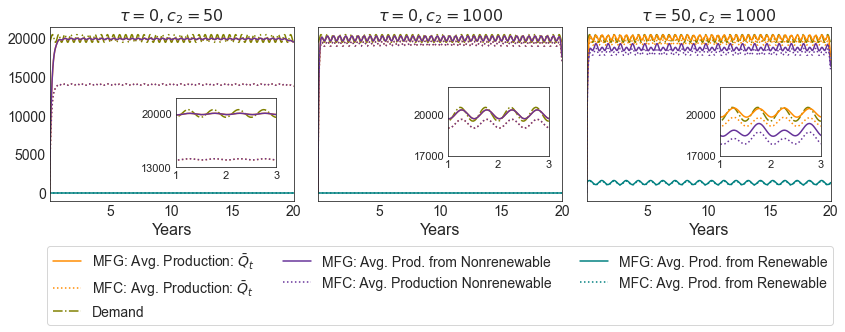

In [13]:
sns.set_style("white")
# fig=plt.figure(figsize=(12,3))
# plt.subplots_adjust(wspace=0.3)
# ax=plt.subplot(131, sharey=True, figsize=(12,3))
fig, ax =plt.subplots(1,3, sharey=True, figsize=(14,3.2))
# plt.yscale("log")
# plt.autoscale(enable=True, axis='y')
plt.subplots_adjust(wspace=0.1)
line1, = ax[0].plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
line2, = ax[0].plot(20*t_grid, np.reshape(MFG_0_10[3][0,0],(np.size(t_grid))), label = "MFG: Avg. Production: $\\bar{Q}_t$", c="darkorange")
line3, = ax[0].plot(20*t_grid, np.reshape(MFG_0_10[4][0,0],(np.size(t_grid))), label = "MFG: Avg. Production from $\\bar{\\tilde{N}}_t$", c="rebeccapurple")
line4, = ax[0].plot(20*t_grid, np.reshape(MFG_0_10[5][0,0],(np.size(t_grid))), label = "MFG: Avg. Production from Renewable", c='teal')
line5, = ax[0].plot(20*t_grid, np.reshape(MFC[3][0,0],(np.size(t_grid))), label = "MFC: Avg. Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
line6, = ax[0].plot(20*t_grid, np.reshape(MFC[4][0,0],(np.size(t_grid))), label = "MFC: Avg. Production from $\\bar{\\tilde{N}}_t$", linestyle=":", c="rebeccapurple")
line7, = ax[0].plot(20*t_grid, np.reshape(MFC[5][0,0],(np.size(t_grid))), label = "MFC: Avg. Production from Renewable", linestyle=":", c='teal')
ax[0].set_xlim(0.01,20.0)
ax[0].set_title("$\\tau=0, c_2=50$",fontdict={'fontsize':16})
ax[0].set_xlabel('Years',fontdict={'fontsize':16})
ax[0].tick_params(axis='both', pad=0.1, labelsize=14)

ax_new = fig.add_axes([0.25, 0.27, 0.1, 0.3])
plt.plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
plt.plot(20*t_grid, np.reshape(MFG_0_10[3][0,0],(np.size(t_grid))), label = "MFG: Production: $\\bar{Q}_t$", c="darkorange")
plt.plot(20*t_grid, np.reshape(MFG_0_10[4][0,0],(np.size(t_grid))), label = "MFG: Avg. Production from $\\bar{\\tilde{N}}_t$", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFG_0_10[5][0,0],(np.size(t_grid))), label = "MFG: Avg. Production from Renewable", c='teal')
plt.plot(20*t_grid, np.reshape(MFC[3][0,0],(np.size(t_grid))), label = "MFC: Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
plt.plot(20*t_grid, np.reshape(MFC[4][0,0],(np.size(t_grid))), label = "MFC: Avg. Production from $\\bar{\\tilde{N}}_t$", linestyle=":", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFC[5][0,0],(np.size(t_grid))), label = "MFC: Avg. Production from Renewable", linestyle=":", c='teal')
plt.xlim(1.0,3.0)
plt.xticks(np.array([1,2,3]))
plt.ylim(13000,22000)
plt.yticks(np.array([13000,20000]))
ax_new.tick_params(labelsize='x-small', pad=0.1)
# ax_new.yaxis.set_major_locator(plt.NullLocator())

# fig=plt.figure()
#ax=plt.subplot(132, sharey=True)
line1, = ax[1].plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
line2, = ax[1].plot(20*t_grid, np.reshape(MFG_0_10[3][0,5],(np.size(t_grid))), label = "MFG: Avg. Production: $\\bar{Q}_t$", c="darkorange")
line3, = ax[1].plot(20*t_grid, np.reshape(MFG_0_10[4][0,5],(np.size(t_grid))), label = "MFG: Avg. Production from $\\bar{\\tilde{N}}_t$", c="rebeccapurple")
line4, = ax[1].plot(20*t_grid, np.reshape(MFG_0_10[5][0,5],(np.size(t_grid))), label = "MFG: Avg. Production from Renewable", c='teal')
line5, = ax[1].plot(20*t_grid, np.reshape(MFC[3][0,5],(np.size(t_grid))), label = "MFC: Avg. Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
line6, = ax[1].plot(20*t_grid, np.reshape(MFC[4][0,5],(np.size(t_grid))), label = "MFC: Avg. Production from $\\bar{\\tilde{N}}_t$", linestyle=":", c="rebeccapurple")
line7, = ax[1].plot(20*t_grid, np.reshape(MFC[5][0,5],(np.size(t_grid))), label = "MFC: Avg. Production from Renewable", linestyle=":", c='teal')
ax[1].set_xlim(0.01,20.0)
ax[1].set_title("$\\tau=0, c_2=1000$",fontdict={'fontsize':16})
ax[1].set_xlabel('Years',fontdict={'fontsize':16})
ax[1].tick_params(axis='x', pad=0.1, labelsize=14)



ax_new = fig.add_axes([0.52, 0.32, 0.1, 0.3])
plt.plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
plt.plot(20*t_grid, np.reshape(MFG_0_10[3][0,5],(np.size(t_grid))), label = "MFG: Production: $\\bar{Q}_t$", c="darkorange")
plt.plot(20*t_grid, np.reshape(MFG_0_10[4][0,5],(np.size(t_grid))), label = "MFG: Avg. Production from $\\bar{\\tilde{N}}_t$", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFG_0_10[5][0,5],(np.size(t_grid))), label = "MFG: Avg. Production from Renewable", c='teal')
plt.plot(20*t_grid, np.reshape(MFC[3][0,5],(np.size(t_grid))), label = "MFC: Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
plt.plot(20*t_grid, np.reshape(MFC[4][0,5],(np.size(t_grid))), label = "MFC: Avg. Production from $\\bar{\\tilde{N}}_t$", linestyle=":", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFC[5][0,5],(np.size(t_grid))), label = "MFC: Avg. Production from Renewable", linestyle=":", c='teal')
plt.xlim(1.0,3.0)
plt.xticks(np.array([1,2,3]))
plt.ylim(17000,22000)
plt.yticks(np.array([17000,20000]))
ax_new.tick_params(labelsize='x-small', pad=0.1)
# ax_new.yaxis.set_major_locator(plt.NullLocator())



# ax=plt.subplot(133, sharey=True)
line1, = ax[2].plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
line2, = ax[2].plot(20*t_grid, np.reshape(MFG_40_50[3][1,5],(np.size(t_grid))), label = "MFG: Avg. Production: $\\bar{Q}_t$", c="darkorange")
line3, = ax[2].plot(20*t_grid, np.reshape(MFG_40_50[4][1,5],(np.size(t_grid))), label = "MFG: Avg. Prod. from Nonrenewable", c="rebeccapurple")
line4, = ax[2].plot(20*t_grid, np.reshape(MFG_40_50[5][1,5],(np.size(t_grid))), label = "MFG: Avg. Prod. from Renewable", c='teal')
line5, = ax[2].plot(20*t_grid, np.reshape(MFC[3][7,5],(np.size(t_grid))), label = "MFC: Avg. Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
line6, = ax[2].plot(20*t_grid, np.reshape(MFC[4][7,5],(np.size(t_grid))), label = "MFC: Avg. Production Nonrenewable", linestyle=":", c="rebeccapurple")
line7, = ax[2].plot(20*t_grid, np.reshape(MFC[5][7,5],(np.size(t_grid))), label = "MFC: Avg. Prod. from Renewable", linestyle=":", c='teal')
ax[2].set_xlim(0.01,20.0)
ax[2].set_title("$\\tau=50, c_2=1000$",fontdict={'fontsize':16})
ax[2].set_xlabel('Years',fontdict={'fontsize':16})
ax[2].tick_params(axis='x', pad=0.1, labelsize=14)
# plt.ylim(18000,22000)

ax_new = fig.add_axes([0.79, 0.32, 0.1, 0.3])
plt.plot(20*t_grid, Dt, label = "Demand", c='olive', linestyle="-.")
plt.plot(20*t_grid, np.reshape(MFG_40_50[3][1,5],(np.size(t_grid))), label = "MFG: Production: $\\bar{Q}_t$", c="darkorange")
plt.plot(20*t_grid, np.reshape(MFG_40_50[4][1,5],(np.size(t_grid))), label = "MFG: Avg. Production from $\\bar{\\tilde{N}}_t$", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFG_40_50[5][1,5],(np.size(t_grid))), label = "MFG: Avg. Production from Renewable", c='teal')
plt.plot(20*t_grid, np.reshape(MFC[3][7,5],(np.size(t_grid))), label = "MFC: Production: $\\bar{Q}_t$", c="darkorange", linestyle=":")
plt.plot(20*t_grid, np.reshape(MFC[4][7,5],(np.size(t_grid))), label = "MFC: Avg. Production from $\\bar{\\tilde{N}}_t$", linestyle=":", c="rebeccapurple")
plt.plot(20*t_grid, np.reshape(MFC[5][7,5],(np.size(t_grid))), label = "MFC: Avg. Production from Renewable", linestyle=":", c='teal')
plt.xlim(1.,3.0)
plt.xticks(np.array([1,2,3]))
plt.ylim(17000,22000)
plt.yticks(np.array([17000,20000]))
ax_new.tick_params(labelsize='x-small', pad=0.1)

# ax_new.yaxis.set_major_locator(plt.NullLocator())


handles, labels = ax.flatten()[-2].get_legend_handles_labels()
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.22), ncol=3, fontsize="14", handles=[line2, line5, line1, line3, line6, line4, line7])
plt.savefig('plots/Jan26/prod_all_3.eps', bbox_inches='tight', format='eps')

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import plottools as pt

fig,ax = plt.subplots()
x = np.linspace(0,1,100)
y = 1-x + 0.02*(2*np.random.random(len(x))-1)
ax.plot(x,y)
ax_zoom = plottools.zoom_axes(fig,ax,[0.1,0.2],[0.8,0.9],[0.6,0.9],[0.6,0.9])
ax_zoom.plot(x,y)
plt.show()

ModuleNotFoundError: No module named 'cs'

## Walkaway Grid

In [142]:
import numpy as np
import os
import pandas as pd

In [143]:
ExpRes = np.array(pd.read_excel("Exp4_5.xlsx", header=None))

In [144]:
MFC_accept = pd.DataFrame(ExpRes[0:11,:])
MFG_accept = pd.DataFrame(ExpRes[11:22,:])
MFC_ren = pd.DataFrame(ExpRes[22:33,:])
MFG_ren = pd.DataFrame(ExpRes[33:44,:])

In [145]:
DemandSatis=np.array([250, 500, 1000, 5000, 10000, 25000, 40000, 60000, 250000, 500000])
Tax = np.array([5000, 1000, 500, 200, 150, 120, 100, 90, 50, 20, 0])

In [7]:
MFC_accept.columns=DemandSatis
MFC_accept.index=Tax

MFG_accept.columns=DemandSatis
MFG_accept.index=Tax

MFC_ren.columns=DemandSatis
MFC_ren.index=Tax

MFG_ren.columns=DemandSatis
MFG_ren.index=Tax

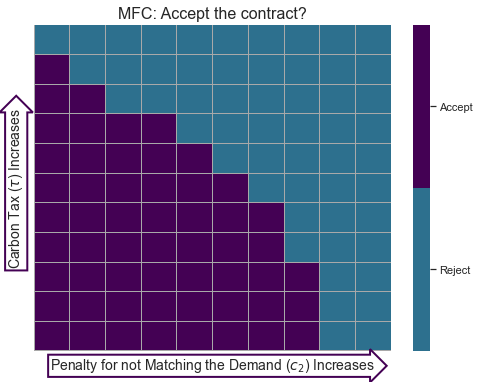

In [147]:
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 6))
colors = ('#2D708EFF', '#440154FF')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(MFC_accept, center=0.5, linewidths=0.01, ax=ax, cmap =cmap, linecolor="darkgray")
# plt.ylabel('Tax',fontdict={'fontsize':16})
# plt.xlabel('$c_2$',fontdict={'fontsize':16})
plt.title('MFC: Accept the contract?',fontdict={'fontsize':16})
plt.xticks(np.array([]))
plt.yticks(np.array([]))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25,0.75])
colorbar.set_ticklabels(['Reject', 'Accept'])

bbox_props = dict(boxstyle="rarrow,pad=0.1", fc="white", ec="#440154FF", lw=2)
t = ax.text(5, 11.5, "Penalty for not Matching the Demand ($c_2$) Increases", ha="center", va="center", rotation=0,
            size=14,
            bbox=bbox_props)

bb = t.get_bbox_patch()

bb.set_boxstyle("rarrow", pad=0.15)


bbox_props = dict(boxstyle="rarrow,pad=0.1", fc="white", ec="#440154FF", lw=2)
t = ax.text(-0.5, 5.5, "Carbon Tax ($\\tau$) Increases", ha="center", va="center", rotation=90,
            size=14,
            bbox=bbox_props)

bb = t.get_bbox_patch()

bb.set_boxstyle("rarrow", pad=0.15)

plt.savefig('plots/Jan26/MFC_accept_v2.eps', bbox_inches='tight', format='eps')

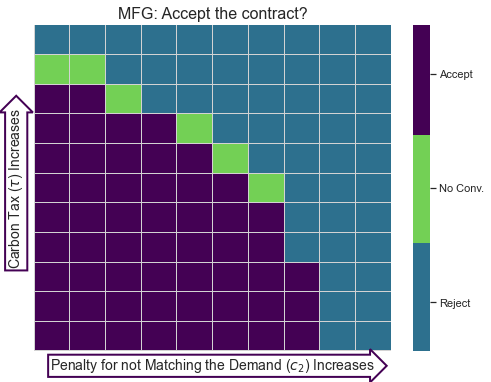

In [148]:
sns.set()

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(8, 6))
colors = ('#2D708EFF', '#73D055FF', '#440154FF')
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

sns.heatmap(MFG_accept, center=0.5, linewidths=0.01, ax=ax, cmap =cmap, linecolor="lightgray")
# plt.ylabel('Tax',fontdict={'fontsize':20})
# plt.xlabel('$c_2$',fontdict={'fontsize':20})
plt.title('MFG: Accept the contract?',fontdict={'fontsize':16})
plt.xticks(np.array([]))
plt.yticks(np.array([]))

bottom, top = ax.get_ylim()
ax.set_ylim(bottom, top)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.15, 0.5, 0.85])
colorbar.set_ticklabels(['Reject', 'No Conv.', 'Accept'])


bbox_props = dict(boxstyle="rarrow,pad=0.1", fc="white", ec="#440154FF", lw=2)
t = ax.text(5, 11.5, "Penalty for not Matching the Demand ($c_2$) Increases", ha="center", va="center", rotation=0,
            size=14,
            bbox=bbox_props)

bb = t.get_bbox_patch()

bb.set_boxstyle("rarrow", pad=0.15)


bbox_props = dict(boxstyle="rarrow,pad=0.1", fc="white", ec="#440154FF", lw=2)
t = ax.text(-0.5, 5.5, "Carbon Tax ($\\tau$) Increases", ha="center", va="center", rotation=90,
            size=14,
            bbox=bbox_props)

bb = t.get_bbox_patch()

bb.set_boxstyle("rarrow", pad=0.15)

plt.savefig('plots/Jan26/MFG_accept_v2.eps', bbox_inches='tight', format='eps')

## Major 2D Convexity

In [15]:
T =     1.0 # over 20 years
Nt =    730 # number of 10 days
t_grid = np.linspace(0,T,Nt,endpoint=True) # grid on [0,T]
Delta_t = t_grid[1]-t_grid[0]

Dt= 20000. - 500. * np.cos(80*np.pi*t_grid) 
theta=5.0
XBar0 = np.array([[0.0],
                  [theta],
                  [0.0],
                  [0.0],
                  [0.0]])

sunk_cost = 1000000000000000

In [19]:
def Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, XBar, XBar0, tau, Nt, Delta_t, c2):
    runningSum = 0
    for n in range(0,Nt):
        runningSum = runningSum + Delta_t * (alpha4 * (XBar[5*n] - Dt[n]) * (XBar[5*n] - Dt[n]))
    major_cost = alpha1 * max(XBar[5*Nt-2] - PBar_star, 0) - alpha2 * tau * (max(XBar[5*Nt-2]-XBar0[3],0)) + \
    alpha3 * (tau-tau_star) * (tau-tau_star) + runningSum + alpha5 * (c2**2)
    return major_cost

In [16]:
MFC = pickle.load(open("data_Jan16/MFC_v3", "rb" ) )

In [17]:
MFG_0_10 = pickle.load(open("data_Jan16/MFG_v3_0_10", "rb" ) )
MFG_15_20 = pickle.load(open("data_Jan16/MFG_v3_15_20", "rb" ) )
MFG_25_30 = pickle.load(open("data_Jan16/MFG_v3_25_30", "rb" ) )
MFG_40_50 = pickle.load(open("data_Jan16/MFG_v3_40_50", "rb" ) )
MFG_75_100 = pickle.load(open("data_Jan16/MFG_v3_75_100", "rb" ) )

In [18]:
taxGrid = np.array([0., 10., 15., 20., 25., 30., 40., 50., 75., 100.])
c2Grid = np.array([50., 100., 250., 500., 750., 1000., 1500., 2000., 2500., 3000., 4000., 5000.])

In [154]:
alpha1 = 1.0
alpha2 = 3.3
alpha3 = 500.
alpha4 = 0.01
alpha5 = 0.25

PBar_star  = 0.0
tau_star = 0.0

MFC_3D = np.zeros((10,12))
MFG_3D = np.zeros((10,12))


i=0
j=0
for tau in taxGrid:
    for c2 in c2Grid:
        MFC_3D[i,j] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFC[7][i*12+j][2][0:5*Nt], XBar0, tau, Nt, Delta_t, c2)
        j =j+1
    i=i+1
    j=0
    

k=0
for c2 in c2Grid:
    MFG_3D[0,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_0_10[7][k][2][0:5*Nt], XBar0, 0., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[1,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_0_10[7][k+12][2][0:5*Nt], XBar0, 10., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[2,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_15_20[7][k][2][0:5*Nt], XBar0, 15., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[3,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_15_20[7][k+12][2][0:5*Nt], XBar0, 20., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[4,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_25_30[7][k][2][0:5*Nt], XBar0, 25., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[5,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_25_30[7][k+12][2][0:5*Nt], XBar0, 30., Nt, Delta_t, c2)
    k=k+1     
    
k=0
for c2 in c2Grid:
    MFG_3D[6,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_40_50[7][k][2][0:5*Nt], XBar0, 40., Nt, Delta_t, c2)
    k=k+1     
      
k=0
for c2 in c2Grid:
    MFG_3D[7,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_40_50[7][k+12][2][0:5*Nt], XBar0, 50., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[8,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_75_100[7][k][2][0:5*Nt], XBar0, 75., Nt, Delta_t, c2)
    k=k+1     
    
k=0
for c2 in c2Grid:
    MFG_3D[9,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_75_100[7][k+12][2][0:5*Nt], XBar0, 100., Nt, Delta_t, c2)
    k=k+1     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


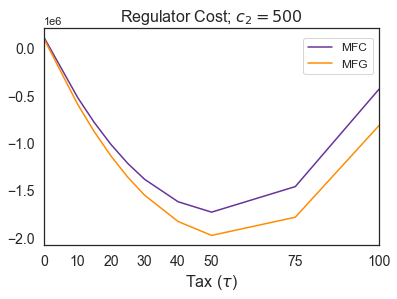

In [177]:
# plt.figure(figsize=(8,5))
sns.set_style("white")
plt.plot(taxGrid, MFC_3D[:,3], c="rebeccapurple", label="MFC")
plt.plot(taxGrid, MFG_3D[:,3], c="darkorange", label="MFG")
plt.xlabel('Tax ($\\tau$)',fontdict={'fontsize':16})
plt.xlim(0,100)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.array([0, 10, 20, 30, 40, 50, 75, 100]))
plt.title("Regulator Cost; $c_2=500$",fontdict={'fontsize':16})
plt.legend(loc='right',bbox_to_anchor=(1., 0.87),ncol =1, fontsize="12")
plt.savefig('plots/Jan26/MajorCost_c2Fixed_500_2.eps', bbox_inches='tight', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


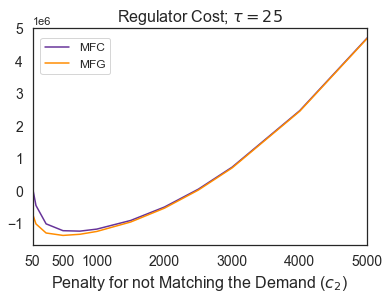

In [176]:
sns.set_style("white")
plt.plot(c2Grid, MFC_3D[4,:], c="rebeccapurple", label = "MFC")
plt.plot(c2Grid, MFG_3D[4,:], c="darkorange", label = "MFG")
plt.xlabel('Penalty for not Matching the Demand ($c_2$)',fontdict={'fontsize':16})
#plt.xlim(50,2000)
#plt.ylim(top=0.5*1.e10)
plt.xlim(50,5000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.array([50, 500, 1000, 2000, 3000, 4000, 5000]))
plt.title("Regulator Cost; $\\tau=25$",fontdict={'fontsize':16})
plt.legend(loc='right',bbox_to_anchor=(0.25, 0.87), ncol =1, fontsize="12")
plt.savefig('plots/Jan26/MajorCost_taxFixed_25_2.eps', bbox_inches='tight', format='eps')

## Major $\alpha_4$ Effect 

In [169]:
#taxGrid = np.array([0., 10., 15., 20., 25., 30., 40., 50., 75., 100.])
MFC_3D_alpha4 = np.zeros((5,12))
c2Grid = np.array([50., 100., 250., 500., 750., 1000., 1500., 2000., 2500., 3000., 4000., 5000.])

alpha1 = 1.0
alpha2 = 3.3
alpha3 = 500.
alpha4 = np.array([0.001, 0.01, 0.1, 1.0, 10.0]) 
alpha5 = 0.25
    
i=0
j=0
for alpha_4 in alpha4:
    for c2 in c2Grid:
        MFC_3D_alpha4[i,j] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha_4, alpha5, PBar_star, tau_star, Dt, MFC[7][4*12+j][2][0:5*Nt], XBar0, 25., Nt, Delta_t, c2)
        j =j+1
    i=i+1
    j=0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


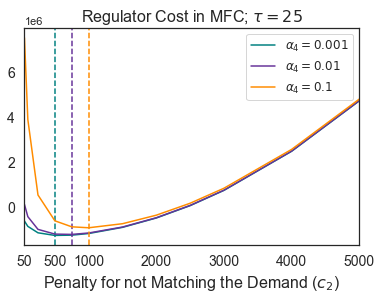

In [178]:
sns.set_style("white")
plt.plot(c2Grid, MFC_3D_alpha4[0,:], c="teal", label = "$\\alpha_4=0.001$")
plt.axvline(x=500, c="teal", linestyle="--")
plt.plot(c2Grid, MFC_3D_alpha4[1,:], c="rebeccapurple", label = "$\\alpha_4=0.01$")
plt.axvline(x=750, c="rebeccapurple", linestyle="--")
plt.plot(c2Grid, MFC_3D_alpha4[2,:], c="darkorange", label = "$\\alpha_4=0.1$")
plt.axvline(x=1000, c="darkorange", linestyle="--")
# plt.plot(c2Grid, MFC_3D_alpha4[3,:], c="olive", label = "$\\alpha_4=0.1$")
#plt.plot(c2Grid, MFC_3D_alpha4[3,:], c="magenta", label = "$\\alpha_4=1$")
#plt.plot(c2Grid, MFC_3D_alpha4[4,:], c="teal", label = "$\\alpha_4=10$")
plt.xlabel('Penalty for not Matching the Demand ($c_2$)',fontdict={'fontsize':16})
#plt.xlim(50,2000)
#plt.ylim(top=0.5*1.e10)
plt.xlim(50,5000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(np.array([50, 500,  1000, 2000, 3000, 4000, 5000]))
plt.title("Regulator Cost in MFC; $\\tau=25$",fontdict={'fontsize':16})
plt.legend(loc='right',bbox_to_anchor=(1., 0.82), ncol =1, fontsize="12")
plt.savefig('plots/Jan26/MajorCost_MFC_alpha4_effect_2.eps', bbox_inches='tight', format='eps')

## Major 3D Graphs

In [20]:
alpha1 = 1.0
alpha2 = 3.3
alpha3 = 500.
alpha4 = 0.01
alpha5 = 0.25

PBar_star  = 0.0
tau_star = 0.0

MFC_3D = np.zeros((10,12))
MFG_3D = np.zeros((10,12))


i=0
j=0
for tau in taxGrid:
    for c2 in c2Grid:
        MFC_3D[i,j] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFC[7][i*12+j][2][0:5*Nt], XBar0, tau, Nt, Delta_t, c2)
        j =j+1
    i=i+1
    j=0
    

k=0
for c2 in c2Grid:
    MFG_3D[0,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_0_10[7][k][2][0:5*Nt], XBar0, 0., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[1,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_0_10[7][k+12][2][0:5*Nt], XBar0, 10., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[2,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_15_20[7][k][2][0:5*Nt], XBar0, 15., Nt, Delta_t, c2)
    k=k+1
    
k=0
for c2 in c2Grid:
    MFG_3D[3,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_15_20[7][k+12][2][0:5*Nt], XBar0, 20., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[4,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_25_30[7][k][2][0:5*Nt], XBar0, 25., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[5,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_25_30[7][k+12][2][0:5*Nt], XBar0, 30., Nt, Delta_t, c2)
    k=k+1     
    
k=0
for c2 in c2Grid:
    MFG_3D[6,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_40_50[7][k][2][0:5*Nt], XBar0, 40., Nt, Delta_t, c2)
    k=k+1     
      
k=0
for c2 in c2Grid:
    MFG_3D[7,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_40_50[7][k+12][2][0:5*Nt], XBar0, 50., Nt, Delta_t, c2)
    k=k+1 
    
k=0
for c2 in c2Grid:
    MFG_3D[8,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_75_100[7][k][2][0:5*Nt], XBar0, 75., Nt, Delta_t, c2)
    k=k+1     
    
k=0
for c2 in c2Grid:
    MFG_3D[9,k] = Calculate_cost_major(alpha1, alpha2, alpha3, alpha4, alpha5, PBar_star, tau_star, Dt, MFG_75_100[7][k+12][2][0:5*Nt], XBar0, 100., Nt, Delta_t, c2)
    k=k+1     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


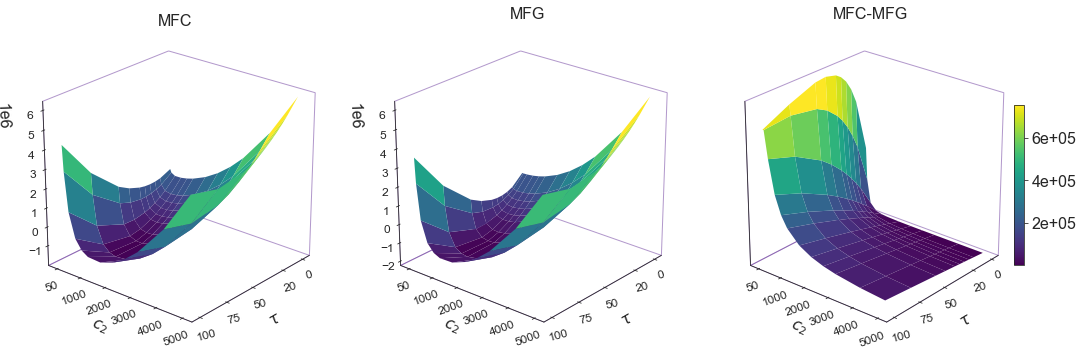

In [63]:
# sns.set_style("white")
fig = plt.figure(figsize=(14,4))
ax0 = fig.add_subplot(131, projection='3d')
ax1 = fig.add_subplot(132, projection='3d')
ax2 = fig.add_subplot(133, projection='3d')
taxGrid3D = taxGrid
c2Grid3D = c2Grid


# Make data.
X, Y = np.meshgrid(taxGrid, c2Grid)
Z_MFC = np.transpose(MFC_3D-MFG_3D)

# Plot the surface.

MFC_plot1 = ax0.plot_surface(X, Y, np.transpose(MFC_3D), cmap= "viridis",
                       linewidth=0)
MFC_plot2 = ax1.plot_surface(X, Y, np.transpose(MFG_3D), cmap= "viridis",
                       linewidth=0)
MFC_plot = ax2.plot_surface(X, Y, Z_MFC, cmap= "viridis",
                       linewidth=0)
# MFG = ax.scatter(X, Y, Z_MFG, c= "maroon",
#                        linewidth=0, antialiased=False, label="MFG")

# ax.set_xticks(taxGrid3D)
# ax.set_yticks(c2Grid3D)

# ax0.set_xticks(np.array([0., 10., 20., 30., 40., 50., 75., 100.]))
ax0.set_xticks(np.array([0.,  20., 50., 75., 100.]))
# ax0.set_yticks(np.array([50., 500., 1000., 1500., 2000., 2500., 3000., 4000., 5000.]))
ax0.set_yticks(np.array([50.,1000., 2000., 3000., 4000., 5000.]))

# ax1.set_xticks(np.array([0., 10., 20., 30., 40., 50., 75., 100.]))
ax1.set_xticks(np.array([0.,  20., 50., 75., 100.]))
# ax1.set_yticks(np.array([50., 500., 1000., 1500., 2000., 2500., 3000., 4000., 5000.]))
ax1.set_yticks(np.array([50., 1000., 2000., 3000., 4000., 5000.]))

# ax2.set_xticks(np.array([0., 10., 20., 30., 40., 50., 75., 100.]))
ax2.set_xticks(np.array([0.,  20., 50., 75., 100.]))
# ax2.set_yticks(np.array([50., 500., 1000., 1500., 2000., 2500., 3000., 4000., 5000.]))
ax2.set_yticks(np.array([50., 1000., 2000., 3000., 4000., 5000.]))


ax0.set_xlabel('$\\tau$')
ax0.set_ylabel('$c_2$')
ax1.set_xlabel('$\\tau$')
ax1.set_ylabel('$c_2$')
ax2.set_xlabel('$\\tau$')
ax2.set_ylabel('$c_2$')
# ax.set_zlabel('Cost', rotation = 90)


ax0.xaxis.pane.fill = False
ax0.yaxis.pane.fill = False
ax0.zaxis.pane.fill = False

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


ax0.xaxis.pane.set_edgecolor('rebeccapurple')
ax0.yaxis.pane.set_edgecolor('rebeccapurple')
ax0.zaxis.pane.set_edgecolor('rebeccapurple')

ax1.xaxis.pane.set_edgecolor('rebeccapurple')
ax1.yaxis.pane.set_edgecolor('rebeccapurple')
ax1.zaxis.pane.set_edgecolor('rebeccapurple')

ax2.xaxis.pane.set_edgecolor('rebeccapurple')
ax2.yaxis.pane.set_edgecolor('rebeccapurple')
ax2.zaxis.pane.set_edgecolor('rebeccapurple')

ax0.grid(False)
ax1.grid(False)
ax2.grid(False)


ax0.tick_params(axis='x',labelsize = 12, labelrotation =15, pad=0.01)
ax0.tick_params(axis='y',labelsize = 12, labelrotation=20, pad=0.01)
ax0.tick_params(axis='z',labelsize = 12, pad=0.01)

ax1.tick_params(axis='x',labelsize = 12, labelrotation =15, pad=0.01)
ax1.tick_params(axis='y',labelsize = 12, labelrotation=20, pad=0.01)
ax1.tick_params(axis='z',labelsize = 12, pad=0.01)

ax2.tick_params(axis='x',labelsize = 12, labelrotation =15, pad=0.01)
ax2.tick_params(axis='y',labelsize = 12, labelrotation=20, pad=0.01)
ax2.tick_params(axis='z',labelsize = 12, pad=0.01)
ax2.ticklabel_format(axis='z', style = 'sci', scilimits=(0,0))
ax2.set_zticks(np.array([]))
# plt.tight_layout()
# ax0.dist = 14
# ax1.dist = 14
# ax2.dist = 14
plt.tight_layout(pad=-1, w_pad=1, h_pad=0.1)

ax0.view_init(25, 40)
ax1.view_init(25, 40)
ax2.view_init(25, 40)
ax0.set_title("MFC", fontsize=16, pad=-0.5)
ax1.set_title("MFG", fontsize=16)
ax2.set_title("MFC-MFG", fontsize=16)
fig.colorbar(MFC_plot, shrink=0.5, aspect=15, format='%.0e', pad=-0.05, fraction=0.1)

# ax1.get_zaxis().get_offset_text().set_position((10,0))


plt.savefig('plots/Jan26/MajorCost_3D_v4.eps', bbox_inches='tight', format='eps')


In [367]:
print(np.where(MFG_3D == np.min(MFG_3D)),np.where(MFC_3D == np.min(MFC_3D)))

(array([5]), array([0])) (array([3]), array([0]))


In [370]:
MFC_3D-MFG_3D

array([[-674174.32482952, -480489.22762189, -258110.15367233,
        -145761.08870531, -101573.25898603,  -77950.37734701,
         -53208.78770278,  -40391.92476065,  -32552.26466494,
         -27261.7788986 ,  -20575.00462409,  -16522.8871471 ],
       [-474918.83681741, -366042.36134883, -213230.25625225,
        -125107.80730268,  -88464.94935951,  -68417.31933289,
         -47078.07915283,  -35886.05766336,  -28993.94237245,
         -24323.02410364,  -18396.42591957,  -14792.51889648],
       [-401070.52951411, -319653.05095454, -193200.69919771,
        -115436.08108785,  -82204.24911778,  -63818.33495394,
         -44087.4681567 ,  -33675.1914156 ,  -27241.7030098 ,
         -22872.33875068,  -17317.62301303,  -13934.05917954],
       [-339579.94324331, -279007.72119858, -174363.92684538,
        -106013.61671311,  -76029.99482242,  -59236.83323612,
         -41100.13585127,  -31440.49190271,  -25472.84711177,
         -21398.81095721,  -16209.14794555,  -13058.06064917],
    